In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import random
import numpy as np
import torch

def set_seed(seed: int):
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Numpy
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN (중요)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PyTorch 2.x (있으면 더 강력)
    torch.use_deterministic_algorithms(True, warn_only=True)

seed = 0
set_seed(seed)

In [3]:
import torch
import torch.nn as nn
from neuralop.data.datasets import DarcyDataset, NavierStokesDataset
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import copy
from tqdm import tqdm
import scipy.io as sio
from typing import Optional, Tuple
import torch.nn.functional as F

# 1. 데이터 불러오기
def get_dataset_loader(dataset_name, batch_size, seed=0):
    if dataset_name == "Burgers":
        root_dir = './data'
        data_file = os.path.join(root_dir, 'burgers_data_R10.mat')
        os.makedirs(root_dir, exist_ok=True)

        data = sio.loadmat(data_file)

        x_data = torch.tensor(data['a'], dtype=torch.float32)[:, ::8].unsqueeze(1)
        y_data = torch.tensor(data['u'], dtype=torch.float32)[:, ::8].unsqueeze(1)

        n_train = 1000
        n_test = 100

        train_dataset = TensorDataset(x_data[:n_train], y_data[:n_train])
        test_dataset  = TensorDataset(
            x_data[n_train:n_train+n_test],
            y_data[n_train:n_train+n_test]
        )

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            generator=g,
            num_workers=0   # 재현성 최우선
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )

    else:
        raise ValueError(f"Dataset {dataset_name} not supported yet.")

    sample_batch = next(iter(train_loader))
    in_channels  = sample_batch[0].shape[1]
    out_channels = sample_batch[1].shape[1]

    return train_loader, test_loader, in_channels, out_channels


# 2. Fine-tuning 함수
def fine_tune(model, optimizer, criterion, train_loader, lr, device):
    model.train()
    # all_outputs = []
    # all_targets = []
    train_loss = 0.0
    

    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # all_outputs.append(outputs.detach().cpu())
        # all_targets.append(targets.detach().cpu())
        train_loss += loss.item()

    # 전체 상대오차 계산
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)

    return model, copy.deepcopy(model.state_dict()), train_loss / len(train_loader)

def studygroup(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr, device):
    model1.train()
    # all_outputs1 = []
    # all_targets1 = []
    train_loss1 = 0.0
    model2.train()
    # all_outputs2 = []
    # all_targets2 = []
    train_loss2 = 0.0
    
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        loss1 = criterion(outputs1, targets)
        loss2 = criterion(outputs2, targets)
        # total_loss1 += loss1.item()
        # total_loss2 += loss2.item()
        
        gap = torch.abs(outputs1 - targets) > torch.abs(outputs2 - targets)
        sign = torch.sign(outputs1 - targets) != torch.sign(outputs2 - targets)
        index1 = torch.where(torch.logical_and(gap, sign))
        index2 = torch.where(torch.logical_and(~gap, sign))
        index3 = torch.where(~sign)
        
        if index1[0].numel() > 0:
            loss1 = criterion(outputs1[index1[0], index1[1], index1[2]], outputs2[index1[0], index1[1], index1[2]].detach())
        if index3[0].numel() > 0:
            loss1 += criterion(outputs1[index3[0], index3[1], index3[2]], targets[index3[0], index3[1], index3[2]])
        loss1.backward()
        optimizer1.step()
        
        if index2[0].numel() > 0:
            loss2 = criterion(outputs2[index2[0], index2[1], index2[2]], outputs1[index2[0], index2[1], index2[2]].detach())
        if index3[0].numel() > 0:
            loss2 += criterion(outputs2[index3[0], index3[1], index3[2]], targets[index3[0], index3[1], index3[2]])        
        loss2.backward()
        optimizer2.step()
        
        # all_outputs1.append(outputs1.detach().cpu())
        # all_targets1.append(targets.detach().cpu())
        # all_outputs2.append(outputs2.detach().cpu())
        # all_targets2.append(targets.detach().cpu())
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        
    # outputs_all1 = torch.cat(all_outputs1, dim=0)
    # targets_all1 = torch.cat(all_targets1, dim=0)
    # rel_error1 = torch.norm(outputs_all1 - targets_all1) / torch.norm(targets_all1)
    # outputs_all2 = torch.cat(all_outputs2, dim=0)
    # targets_all2 = torch.cat(all_targets2, dim=0)
    # rel_error2 = torch.norm(outputs_all2 - targets_all2) / torch.norm(targets_all2)
    return model1, model2, copy.deepcopy(model1.state_dict()), copy.deepcopy(model2.state_dict()), train_loss1 / len(train_loader), train_loss2 / len(train_loader)

# 7. 평가 함수
def evaluate(model, test_loader, device):
    # criterion = nn.MSELoss()
    # model.eval()
    # test_loss = 0.0
    # with torch.no_grad():
    #     for batch in test_loader:
    #         inputs, targets = batch["x"].to(device), batch["y"].to(device)
    #         outputs = model(inputs)
    #         test_loss += criterion(outputs, targets).item()
    # return test_loss / len(test_loader)

    model.eval()
    total_rel_l2 = 0.0
    count = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            targets = batch[1].to(device)
            outputs = model(inputs)

            diff = outputs - targets

            diff_norm = torch.norm(diff.view(diff.size(0), -1), dim=1)
            target_norm = torch.norm(targets.view(targets.size(0), -1), dim=1)

            rel_l2 = diff_norm / (target_norm + 1e-12)
            total_rel_l2 += rel_l2.sum().item()
            count += rel_l2.size(0)

    return total_rel_l2 / count

class DeepONetWrapper(nn.Module):
    def __init__(self, deeponet, resolution):
        super().__init__()
        self.model = deeponet
        self.N = resolution

    def forward(self, x):
        # x: (B, 1, N)
        B, _, N = x.shape
        u_branch = x.squeeze(1)

        coord = torch.linspace(
            0, 1, N, device=x.device
        ).view(1, N, 1).repeat(B, 1, 1)

        return self.model((u_branch, coord))

In [4]:
from models.fno import FNO1D
from models.deeponet import DeepONet1D
from models.multibranchdeeponet import MultiBranchDeepONet1D, MultiBranchDeepONet1DWrapper
from models.gnot import GNOT1D

set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Darcy Flow 데이터셋 로드 및 입력 채널 확인
train_loader, test_loader, in_channels, out_channels = get_dataset_loader("Burgers", batch_size=32)

# FNO 모델 초기화
pretrained_model1 = FNO1D(modes=16, width=64, in_ch=1, out_ch=1).to(device)
pretrained_model2 = MultiBranchDeepONet1DWrapper(MultiBranchDeepONet1D(global_dim=1024, local_dim=64, stats_dim=3).to(device), resolution=1024, local_points=64,).to(device)
pretrained_model3 = DeepONetWrapper(DeepONet1D(branch_dim=1024, hidden=128, depth=3),resolution=1024).to(device)
pretrained_model4 = GNOT1D(in_channels=1, out_channels=1, width=64, n_latents=64).to(device)


print(pretrained_model1)
print(pretrained_model3)
print(pretrained_model4)

In [4]:
epochs = 1000
seed=0
torch.cuda.empty_cache()
torch.manual_seed(seed)

model1 = copy.deepcopy(pretrained_model1).to(device)
model2 = copy.deepcopy(pretrained_model2).to(device)
model3 = copy.deepcopy(pretrained_model3).to(device)
model4 = copy.deepcopy(pretrained_model4).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

torch.cuda.empty_cache()
# fine_tuned_models1 = []
train_loss_save1 = []
test_loss_save1 = []
for epoch in tqdm(range(epochs)):
    model1, weight1, loss1 = fine_tune(model1, optimizer1, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save1.append(loss1)
    # fine_tuned_models1.append(weight1)
    test_loss1 = evaluate(model1, test_loader, device)
    test_loss_save1.append(test_loss1)

# torch.cuda.empty_cache()
# # fine_tuned_models2 = []
# train_loss_save2 = []
# test_loss_save2 = []
# for epoch in tqdm(range(epochs)):
#     model2, weight2, loss2 = fine_tune(model2, optimizer2, criterion, train_loader, lr=1e-3, device=device)
#     train_loss_save2.append(loss2)
#     # fine_tuned_models2.append(weight2)
#     test_loss2 = evaluate(model2, test_loader, device)
#     test_loss_save2.append(test_loss2)
    
torch.cuda.empty_cache()
# fine_tuned_models3 = []
train_loss_save3 = []
test_loss_save3 = []
for epoch in tqdm(range(epochs)):
    model3, weight3, loss3 = fine_tune(model3, optimizer3, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save3.append(loss3)
    # fine_tuned_models3.append(weight3)
    test_loss3 = evaluate(model3, test_loader, device)
    test_loss_save3.append(test_loss3)

torch.cuda.empty_cache()
# fine_tuned_models4 = []
train_loss_save4 = []
test_loss_save4 = []
for epoch in tqdm(range(epochs)):
    model4, weight4, loss4 = fine_tune(model4, optimizer4, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save4.append(loss4)
    # fine_tuned_models1.append(weight1)
    test_loss4 = evaluate(model4, test_loader, device)
    test_loss_save4.append(test_loss4)

100%|███████████████████████████████████████| 1000/1000 [18:15<00:00,  1.10s/it]


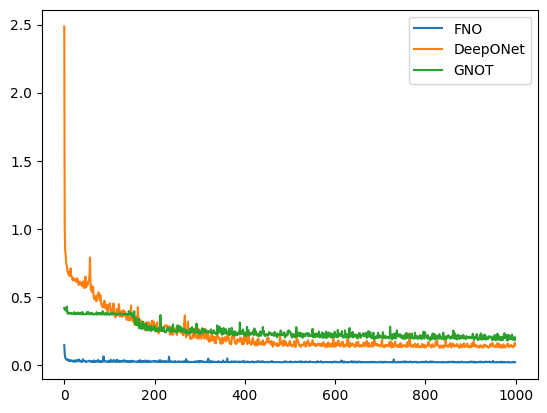

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[:], test_loss_save1[:], label='FNO')
# plt.plot(range(1000)[:], test_loss_save2[:], label='MBDeepONet')
plt.plot(range(1000)[:], test_loss_save3[:], label='DeepONet')
plt.plot(range(1000)[:], test_loss_save4[:], label='GNOT')
plt.legend()
plt.show()

set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model12 = copy.deepcopy(pretrained_model1).to(device)
model21 = copy.deepcopy(pretrained_model2).to(device)
optimizer12 = torch.optim.Adam(model12.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer21 = torch.optim.Adam(model21.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11 = []
train_loss_save12 = []
test_loss_save12 = []
# fine_tuned_models22 = []
train_loss_save21 = []
test_loss_save21 = []
for epoch in tqdm(range(epochs)):
    model12, model21, weight12, weight21, loss12, loss21 = studygroup(model12, model21, optimizer12, optimizer21, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save12.append(loss12)
    # fine_tuned_models12.append(weight12)
    test_loss12 = evaluate(model12, test_loader, device)
    test_loss_save12.append(test_loss12)
        
    train_loss_save21.append(loss21)
    # fine_tuned_models21.append(weight21)
    test_loss21 = evaluate(model21, test_loader, device)
    test_loss_save21.append(test_loss21)


import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save2[200:], label='MBDeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save12[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save21[200:], label='Our MBDeepONet')
plt.legend()
plt.show()

# 평가
mse_base1 = min(test_loss_save1)
mse_base2 = min(test_loss_save2)
mse_study12 = min(test_loss_save12)
mse_study21 = min(test_loss_save21)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study12 MSE: {mse_study12}")
print(f"Model Study21 MSE: {mse_study21}")

In [6]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model13 = copy.deepcopy(pretrained_model1).to(device)
model31 = copy.deepcopy(pretrained_model3).to(device)
optimizer13 = torch.optim.Adam(model13.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer31 = torch.optim.Adam(model31.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models13 = []
train_loss_save13 = []
test_loss_save13 = []
# fine_tuned_models31 = []
train_loss_save31 = []
test_loss_save31 = []
for epoch in tqdm(range(epochs)):
    model13, model31, weight13, weight31, loss13, loss31 = studygroup(model13, model31, optimizer13, optimizer31, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save13.append(loss13)
    # fine_tuned_models13.append(weight13)
    test_loss13 = evaluate(model13, test_loader, device)
    test_loss_save13.append(test_loss13)
        
    train_loss_save31.append(loss31)
    # fine_tuned_models31.append(weight31)
    test_loss31 = evaluate(model31, test_loader, device)
    test_loss_save31.append(test_loss31)


100%|███████████████████████████████████████| 1000/1000 [20:07<00:00,  1.21s/it]


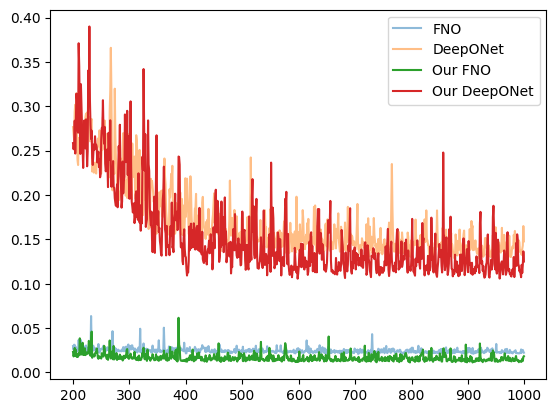

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save13[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save31[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [8]:
# 평가
mse_base1 = min(test_loss_save1)
mse_base3 = min(test_loss_save3)
mse_study13 = min(test_loss_save13)
mse_study31 = min(test_loss_save31)

print(f"Model Base1 L2: {mse_base1}")
print(f"Model Base3 L2: {mse_base3}")
print(f"Model Study13 L2: {mse_study13}")
print(f"Model Study31 L2: {mse_study31}")

Model Base1 L2: 0.020848641842603682
Model Base3 L2: 0.12861909687519074
Model Study13 L2: 0.01115944966673851
Model Study31 L2: 0.10563276648521423


In [9]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model14 = copy.deepcopy(pretrained_model1).to(device)
model41 = copy.deepcopy(pretrained_model4).to(device)
optimizer14 = torch.optim.Adam(model14.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer41 = torch.optim.Adam(model41.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models13 = []
train_loss_save14 = []
test_loss_save14 = []
# fine_tuned_models31 = []
train_loss_save41 = []
test_loss_save41 = []
for epoch in tqdm(range(epochs)):
    model14, model41, weight14, weight41, loss14, loss41 = studygroup(model14, model41, optimizer14, optimizer41, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save14.append(loss14)
    # fine_tuned_models13.append(weight13)
    test_loss14 = evaluate(model14, test_loader, device)
    test_loss_save14.append(test_loss14)
        
    train_loss_save41.append(loss41)
    # fine_tuned_models31.append(weight31)
    test_loss41 = evaluate(model41, test_loader, device)
    test_loss_save41.append(test_loss41)
    

100%|███████████████████████████████████████| 1000/1000 [29:07<00:00,  1.75s/it]


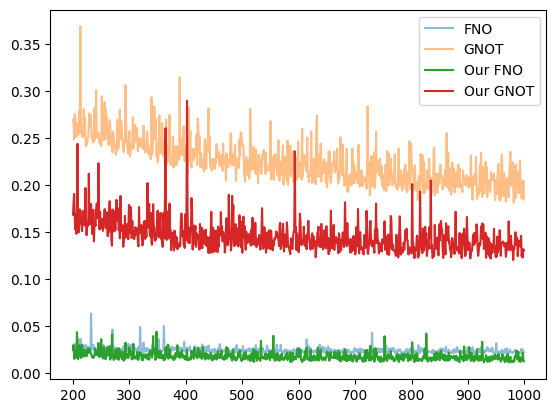

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save4[200:], label='GNOT', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save14[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save41[200:], label='Our GNOT')
plt.legend()
plt.show()

In [11]:
# 평가
mse_base1 = min(test_loss_save1)
mse_base4 = min(test_loss_save4)
mse_study14 = min(test_loss_save14)
mse_study41 = min(test_loss_save41)

print(f"Model Base1 L2: {mse_base1}")
print(f"Model Base4 L2: {mse_base4}")
print(f"Model Study14 L2: {mse_study14}")
print(f"Model Study41 L2: {mse_study41}")

Model Base1 L2: 0.020848641842603682
Model Base4 L2: 0.18150069296360016
Model Study14 L2: 0.011512343809008597
Model Study41 L2: 0.12041614055633545


set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model23 = copy.deepcopy(pretrained_model2).to(device)
model32 = copy.deepcopy(pretrained_model3).to(device)
optimizer23 = torch.optim.Adam(model23.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer32 = torch.optim.Adam(model32.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save23 = []
test_loss_save23 = []
# fine_tuned_models32 = []
train_loss_save32 = []
test_loss_save32 = []
for epoch in tqdm(range(epochs)):
    model23, model32, weight23, weight32, loss23, loss32 = studygroup(model23, model32, optimizer23, optimizer32, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save23.append(loss23)
    # fine_tuned_models23.append(weight23)
    test_loss23 = evaluate(model23, test_loader, device)
    test_loss_save23.append(test_loss23)
        
    train_loss_save32.append(loss32)
    # fine_tuned_models32.append(weight32)
    test_loss32 = evaluate(model32, test_loader, device)
    test_loss_save32.append(test_loss32)


import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='MBDeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save23[200:], label='Our MBDeepONet')
plt.plot(range(1000)[200:], test_loss_save32[200:], label='Our DeepONet')
plt.legend()
plt.show()

# 평가
mse_base2 = min(test_loss_save2)
mse_base3 = min(test_loss_save3)
mse_study23 = min(test_loss_save23)
mse_study32 = min(test_loss_save32)

print(f"Model Base2 L2: {mse_base2}")
print(f"Model Base3 L2: {mse_base3}")
print(f"Model Study23 L2: {mse_study23}")
print(f"Model Study32 L2: {mse_study32}")

set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model24 = copy.deepcopy(pretrained_model2).to(device)
model42 = copy.deepcopy(pretrained_model4).to(device)
optimizer24 = torch.optim.Adam(model24.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer42 = torch.optim.Adam(model42.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save24 = []
test_loss_save24 = []
# fine_tuned_models32 = []
train_loss_save42 = []
test_loss_save42 = []
for epoch in tqdm(range(epochs)):
    model24, model42, weight24, weight42, loss24, loss42 = studygroup(model24, model42, optimizer24, optimizer42, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save24.append(loss24)
    # fine_tuned_models23.append(weight23)
    test_loss24 = evaluate(model24, test_loader, device)
    test_loss_save24.append(test_loss24)
        
    train_loss_save42.append(loss42)
    # fine_tuned_models32.append(weight32)
    test_loss42 = evaluate(model42, test_loader, device)
    test_loss_save42.append(test_loss42)


import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='MBDeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save4[200:], label='GNOT', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save24[200:], label='Our MBDeepONet')
plt.plot(range(1000)[200:], test_loss_save42[200:], label='Our GNOT')
plt.legend()
plt.show()

# 평가
mse_base2 = min(test_loss_save2)
mse_base4 = min(test_loss_save4)
mse_study24 = min(test_loss_save24)
mse_study42 = min(test_loss_save42)

print(f"Model Base2 L2: {mse_base2}")
print(f"Model Base4 L2: {mse_base4}")
print(f"Model Study24 L2: {mse_study24}")
print(f"Model Study42 L2: {mse_study42}")

In [12]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model34 = copy.deepcopy(pretrained_model3).to(device)
model43 = copy.deepcopy(pretrained_model4).to(device)
optimizer34 = torch.optim.Adam(model34.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer43 = torch.optim.Adam(model43.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save34 = []
test_loss_save34 = []
# fine_tuned_models32 = []
train_loss_save43 = []
test_loss_save43 = []
for epoch in tqdm(range(epochs)):
    model34, model43, weight34, weight43, loss34, loss43 = studygroup(model34, model43, optimizer34, optimizer43, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save34.append(loss34)
    # fine_tuned_models23.append(weight23)
    test_loss34 = evaluate(model34, test_loader, device)
    test_loss_save34.append(test_loss34)
        
    train_loss_save43.append(loss43)
    # fine_tuned_models32.append(weight32)
    test_loss43 = evaluate(model43, test_loader, device)
    test_loss_save43.append(test_loss43)


100%|███████████████████████████████████████| 1000/1000 [35:46<00:00,  2.15s/it]


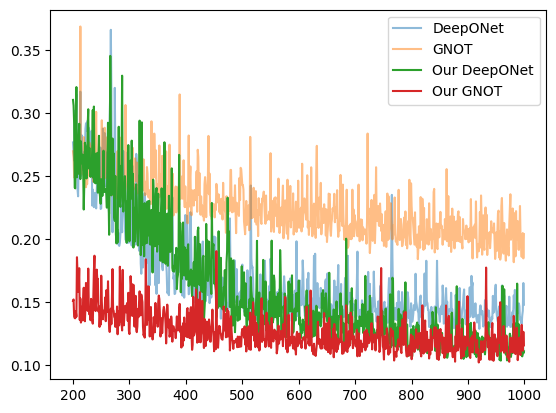

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save4[200:], label='GNOT', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save34[200:], label='Our DeepONet')
plt.plot(range(1000)[200:], test_loss_save43[200:], label='Our GNOT')
plt.legend()
plt.show()

In [14]:
# 평가
mse_base3 = min(test_loss_save3)
mse_base4 = min(test_loss_save4)
mse_study34 = min(test_loss_save34)
mse_study43 = min(test_loss_save43)

print(f"Model Base3 L2: {mse_base3}")
print(f"Model Base4 L2: {mse_base4}")
print(f"Model Study34 L2: {mse_study34}")
print(f"Model Study43 L2: {mse_study43}")

Model Base3 L2: 0.12861909687519074
Model Base4 L2: 0.18150069296360016
Model Study34 L2: 0.10338295459747314
Model Study43 L2: 0.10189589738845825


In [15]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model11a = copy.deepcopy(pretrained_model1).to(device)
model11b = copy.deepcopy(pretrained_model1).to(device)
optimizer11a = torch.optim.Adam(model11a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer11b = torch.optim.Adam(model11b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11a = []
train_loss_save11a = []
test_loss_save11a = []
# fine_tuned_models11b = []
train_loss_save11b = []
test_loss_save11b = []
for epoch in tqdm(range(epochs)):
    model11a, model11b, weight11a, weight11b, loss11a, loss11b = studygroup(model11a, model11b, optimizer11a, optimizer11b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save11a.append(loss11a)
    # fine_tuned_models23.append(weight23)
    test_loss11a = evaluate(model11a, test_loader, device)
    test_loss_save11a.append(test_loss11a)
        
    train_loss_save11b.append(loss11b)
    # fine_tuned_models11b.append(weight11b)
    test_loss11b = evaluate(model11b, test_loader, device)
    test_loss_save11b.append(test_loss11b)


100%|███████████████████████████████████████| 1000/1000 [18:11<00:00,  1.09s/it]


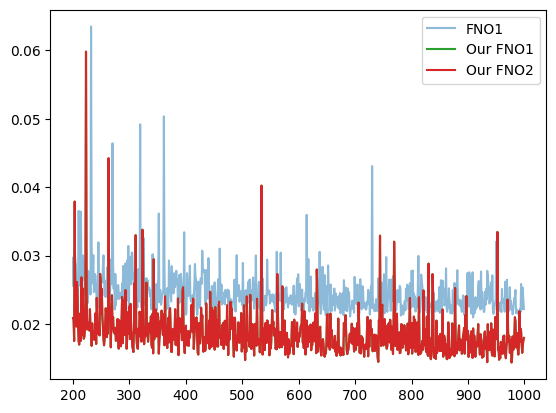

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save11a[200:], label='Our FNO1', color='C2')
plt.plot(range(1000)[200:], test_loss_save11b[200:], label='Our FNO2', color='C3')
plt.legend()
plt.show()

In [17]:
# 평가
mse_base1 = min(test_loss_save1)
mse_study11a = min(test_loss_save11a)
mse_study11b = min(test_loss_save11b)

print(f"Model Base1 L2: {mse_base1}")
print(f"Model Study11a L2: {mse_study11a}")
print(f"Model Study11b L2: {mse_study11b}")

Model Base1 L2: 0.020848641842603682
Model Study11a L2: 0.014379748329520225
Model Study11b L2: 0.014379748329520225


set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model22a = copy.deepcopy(pretrained_model2).to(device)
model22b = copy.deepcopy(pretrained_model2).to(device)
optimizer22a = torch.optim.Adam(model22a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer22b = torch.optim.Adam(model22b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models22a = []
train_loss_save22a = []
test_loss_save22a = []
# fine_tuned_models22b = []
train_loss_save22b = []
test_loss_save22b = []
for epoch in tqdm(range(epochs)):
    model22a, model22b, weight22a, weight22b, loss22a, loss22b = studygroup(model22a, model22b, optimizer22a, optimizer22b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save22a.append(loss22a)
    # fine_tuned_models22.append(weight22)
    test_loss22a = evaluate(model22a, test_loader, device)
    test_loss_save22a.append(test_loss22a)
        
    train_loss_save22b.append(loss22b)
    # fine_tuned_models22b.append(weight22b)
    test_loss22b = evaluate(model22b, test_loader, device)
    test_loss_save22b.append(test_loss22b)


import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNO1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save22a[200:], label='Our UNO1', color='C2')
plt.plot(range(1000)[200:], test_loss_save22b[200:], label='Our UNO2', color='C3')
plt.legend()
plt.show()

# 평가
mse_base2 = min(test_loss_save2)
mse_study22a = min(test_loss_save22a)
mse_study22b = min(test_loss_save22b)

print(f"Model Base2 L2: {mse_base2}")
print(f"Model Study22a L2: {mse_study22a}")
print(f"Model Study22b L2: {mse_study22b}")

In [18]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model33a = copy.deepcopy(pretrained_model3).to(device)
model33b = copy.deepcopy(pretrained_model3).to(device)
optimizer33a = torch.optim.Adam(model33a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer33b = torch.optim.Adam(model33b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models33a = []
train_loss_save33a = []
test_loss_save33a = []
# fine_tuned_models33b = []
train_loss_save33b = []
test_loss_save33b = []
for epoch in tqdm(range(epochs)):
    model33a, model33b, weight33a, weight33b, loss33a, loss33b = studygroup(model33a, model33b, optimizer33a, optimizer33b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save33a.append(loss33a)
    # fine_tuned_models33.append(weight33)
    test_loss33a = evaluate(model33a, test_loader, device)
    test_loss_save33a.append(test_loss33a)
        
    train_loss_save33b.append(loss33b)
    # fine_tuned_models33b.append(weight33b)
    test_loss33b = evaluate(model33b, test_loader, device)
    test_loss_save33b.append(test_loss33b)


100%|███████████████████████████████████████| 1000/1000 [21:41<00:00,  1.30s/it]


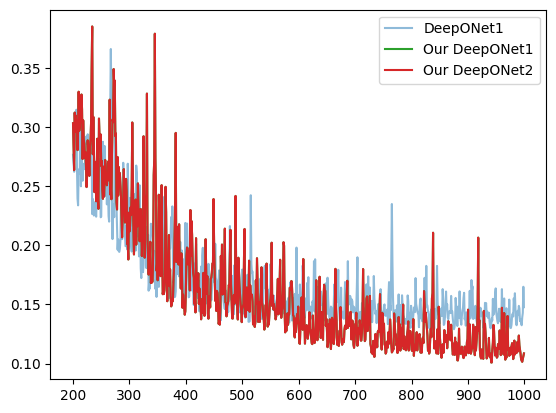

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save33a[200:], label='Our DeepONet1', color='C2')
plt.plot(range(1000)[200:], test_loss_save33b[200:], label='Our DeepONet2', color='C3')
plt.legend()
plt.show()

In [20]:
# 평가
mse_base3 = min(test_loss_save3)
mse_study33a = min(test_loss_save33a)
mse_study33b = min(test_loss_save33b)

print(f"Model Base3 L2: {mse_base3}")
print(f"Model Study33a L2: {mse_study33a}")
print(f"Model Study33b L2: {mse_study33b}")

Model Base3 L2: 0.12861909687519074
Model Study33a L2: 0.10096660554409027
Model Study33b L2: 0.10096660554409027


In [21]:
set_seed(seed)

torch.cuda.empty_cache()
# Study Group 학습
model44a = copy.deepcopy(pretrained_model4).to(device)
model44b = copy.deepcopy(pretrained_model4).to(device)
optimizer44a = torch.optim.Adam(model44a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer44b = torch.optim.Adam(model44b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models33a = []
train_loss_save44a = []
test_loss_save44a = []
# fine_tuned_models33b = []
train_loss_save44b = []
test_loss_save44b = []
for epoch in tqdm(range(epochs)):
    model44a, model44b, weight44a, weight44b, loss44a, loss44b = studygroup(model44a, model44b, optimizer44a, optimizer44b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save44a.append(loss44a)
    # fine_tuned_models33.append(weight33)
    test_loss44a = evaluate(model44a, test_loader, device)
    test_loss_save44a.append(test_loss44a)
        
    train_loss_save44b.append(loss44b)
    # fine_tuned_models33b.append(weight33b)
    test_loss44b = evaluate(model44b, test_loader, device)
    test_loss_save44b.append(test_loss44b)


100%|███████████████████████████████████████| 1000/1000 [38:48<00:00,  2.33s/it]


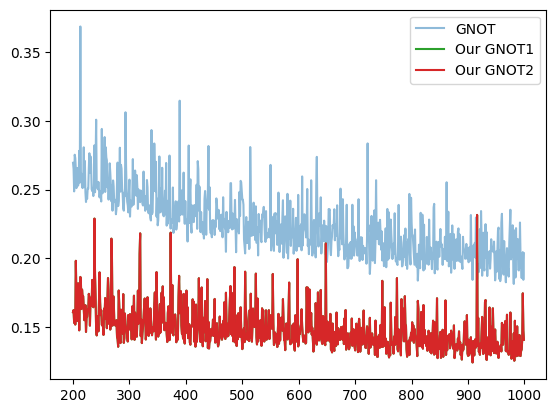

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save4[200:], label='GNOT', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save44a[200:], label='Our GNOT1', color='C2')
plt.plot(range(1000)[200:], test_loss_save44b[200:], label='Our GNOT2', color='C3')
plt.legend()
plt.show()

In [23]:
# 평가
mse_base4 = min(test_loss_save4)
mse_study44a = min(test_loss_save44a)
mse_study44b = min(test_loss_save44b)

print(f"Model Base4 L2: {mse_base4}")
print(f"Model Study44a L2: {mse_study44a}")
print(f"Model Study44b L2: {mse_study44b}")

Model Base4 L2: 0.18150069296360016
Model Study44a L2: 0.12441459238529205
Model Study44b L2: 0.12441459238529205


In [24]:
torch.cuda.empty_cache()

In [25]:
import matplotlib.pyplot as plt
# 첫 번째 배치 가져오기
batch = next(iter(test_loader))
inputs = batch['x']  # Shape: (16, 1, 128, 128)
targets = batch['y']  # Shape: (16, 1, 128, 128)

# 시각화를 위해 NumPy 배열로 변환
# inputs = inputs.cpu().numpy()  # (16, 1, 128, 128)
targets = targets.cpu().numpy()  # (16, 1, 128, 128)

num_samples = 2
fig, axes = plt.subplots(num_samples, 4, figsize=(12, 4 * num_samples))

best_model3.eval()
best_model32.eval()

for i in range(num_samples):
    # 입력 데이터
    ax = axes[i, 0]
    im = ax.imshow(inputs.cpu().numpy()[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Input')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # independent
    ax = axes[i, 1]
    im = ax.imshow(best_model3(inputs.to(device))[i, 0].detach().cpu().numpy(), cmap='viridis', origin='lower')
    ax.set_title(f'DeepONet(independent)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # 타겟 데이터
    ax = axes[i, 2]
    im = ax.imshow(targets[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Target')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # ssmo
    ax = axes[i, 3]
    im = ax.imshow(best_model32(inputs.to(device))[i, 0].detach().cpu().numpy(), cmap='viridis', origin='lower')
    ax.set_title(f'DeepONet_unet(Our)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str